In [1]:
from __future__ import print_function
import jsonlines
import re
import json
import nltk
import io
import numpy as np
from keras.layers import Embedding
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
# start - <sos> tag
# stop - <eos> tag

#split records into list of impression, findings
def splitReports(File):
    
    impression_list = []
    findings_list = []
    
    with open(File,'r') as file:
        for line in file:
            all = line
        
    report_list = re.findall(r'{.*?}',all)

    for report in report_list:
        obj = json.loads(report)
        # indication_list.append(str(obj['Indication']))
        impression_list.append('start ' + str(obj['impression']) + ' stop')
        findings_list.append(str(obj['findings']))
        
    return (findings_list, impression_list)    

In [3]:
#get vocab of indications, impression, findings
def getVocabularySets(findings_list, impression_list):
    # indication_vocab_set = set()
    impression_vocab_set = set()
    findings_vocab_set = set()
    common_vocab_set = set()

    #for item in indication_list:
     #   for word in nltk.word_tokenize(item):
      #      indication_vocab_set.add(word.lower())
        
    for item in impression_list:
        for word in nltk.word_tokenize(item):
            impression_vocab_set.add(word.lower())
        
    for item in findings_list:
        for word in nltk.word_tokenize(item):
            findings_vocab_set.add(word.lower())
        
    # common_vocab_set.update(indication_vocab_set)
    common_vocab_set.update(impression_vocab_set)
    common_vocab_set.update(findings_vocab_set)
    
    return (common_vocab_set, findings_vocab_set, impression_vocab_set)

In [4]:
# get the embedding  matrix
def loadGloVeModel(gloVe_file):
    embedding_model = {}
    
    with io.open(gloVe_file, encoding = 'utf8') as f:
        word_embeddings = f.readlines()
        
    for word_embedding_line in word_embeddings:
        word_embedding = word_embedding_line.split()
        word = word_embedding[0]
        embedding = np.array([float(col) for col in word_embedding[1:]])
        embedding_model[word] = embedding
            
    return embedding_model

In [5]:
#get max sequences 
def getMaxSeq(List):
        
    max_len = 0
    for item in List:
        item_len = len(item.split())
        if item_len > max_len:
            max_len = item_len
    
    return max_len

In [6]:
findings, impression = splitReports('reports.jsonl')
common_vocab, findings_vocab, impression_vocab = getVocabularySets(findings, impression)

common = []
common.extend(findings)
#common.extend(indications)
common.extend(impression)

#max_indication_len = getMaxSeq(indications)
findings_MAXLEN = getMaxSeq(findings)
impression_MAXLEN = getMaxSeq(impression)

MAXLEN = max(findings_MAXLEN,impression_MAXLEN)
#MAX_LEN = 100 #99

In [7]:
#embedding_model = loadGloVeModel('radglove.800M.100d.txt')
#findings_MAXLEN
impression_MAXLEN

139

In [8]:
#embedding dimension
#EMBEDDING_DIM = 100

findings_MAXLEN

187

In [9]:
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(common)

#word_to_index = tokenizer.word_index

#indication_sequences = tokenizer.texts_to_sequences(indications)

#findings_sequences = tokenizer.texts_to_sequences(findings)
#impression_sequences = tokenizer.texts_to_sequences(impression)

#indication_data = pad_sequences(indication_sequences, maxlen = MAXLEN)

#findings_data = pad_sequences(findings_sequences, maxlen = MAX_LEN)
#impression_data = pad_sequences(impression_sequences, maxlen = MAX_LEN)

word_2_index = dict([(word, i) for i, word in enumerate(common_vocab)])

#I_word_2_index = dict([(word, i) for i, word in enumerate(impression_vocab)])

In [10]:
index_2_word = {}
for word,index in word_2_index.items():
    index_2_word[index] = word
    
#I_index_2_word = {}
#for word,index in I_word_2_index.items():
#    I_index_2_word[index] = word

In [11]:
embedding_model = loadGloVeModel('radglove.800M.100d.txt')

EMBEDDING_DIM = 100

embedding_matrix = np.zeros((len(common_vocab),EMBEDDING_DIM))
# inverse_embedding_matrix = np.zeros((EMBEDDING_DIM, len(findings_vocab)))

inverse_embedding_matrix = {}
for word,index in word_2_index.items():
    embedding_vector = embedding_model.get(word)
    
    if embedding_vector is not None :
        embedding_matrix[index] = embedding_vector

In [12]:
# check doc.s once
# trainable=False to prevent the weights from being updated during training
embedding_layer = Embedding(len(common_vocab), EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), trainable=False)

In [13]:
len(common_vocab)

2070

In [14]:
findings_data = np.zeros(
    (len(findings), findings_MAXLEN),
    dtype='float32')
#impression_data = np.zeros(
#    (len(impression), impression_MAXLEN),
#    dtype='float32')
target_data = np.zeros(
    (len(impression), impression_MAXLEN, len(common_vocab)),
    dtype='float32')

In [15]:
target_data.shape

(2691, 139, 2070)

In [16]:
def toLowerCase(findings, impression):
    new_findings = []
    new_impression = []
    for sent in findings:
        new_sent = ""
        for word in sent.split():
            new_sent = new_sent + word.lower() + ' '
        new_findings.append(new_sent) 

    for sent in impression:
        new_sent = ""
        for word in sent.split():
            new_sent = new_sent + word.lower() + ' '
        new_impression.append(new_sent)
        
    return (new_findings, new_impression)

findings, impression = toLowerCase(findings, impression)

In [17]:
for i, (FINDINGS, IMPRESSION) in enumerate(zip(findings, impression)):
    for t, word in enumerate(nltk.word_tokenize(FINDINGS)):
        findings_data[i, t] = word_2_index[word]
        
    for t, word in enumerate(nltk.word_tokenize(IMPRESSION)):
        #impression_data[i, t] = I_word_2_index[word_i]
        
        if t > 0:
            target_data[i, t-1, word_2_index[word]] = 1

In [19]:
#Remove attention

from keras.models import Model 
from keras.layers import Average, Input, GRU, Dense, TimeDistributed, Add, Activation, RepeatVector, Flatten, Permute, Lambda, Multiply, Concatenate
from keras import backend as K
import matplotlib.pyplot as plt 

# a ----> attention of findings encoder
n_features = 100
epochs = 30
batch_size = 60

##ENCODER
encoder_inputs = Input(shape = (findings_MAXLEN,), dtype = 'float32')

encoder_embeds = embedding_layer(encoder_inputs)

forward_Encoder = GRU(100, return_sequences = False, return_state = True)
backward_Encoder = GRU(100, return_sequences = False, return_state = True, go_backwards = True)

forward_encoder_states, forward_h = forward_Encoder(encoder_embeds) #return state is by default True
backward_encoder_states, backward_h = backward_Encoder(encoder_embeds)

encoder_state = Concatenate()([forward_h, backward_h])

state = encoder_state
#__________#__________#__________#__________#__________#_________#__________#__________#_______________________________________________________

##DECODER
decoder_input = Input(shape = (1,len(common_vocab),), dtype = 'float32')

Decoder = GRU(200, return_sequences = True, return_state = True)

densor = Dense(len(common_vocab), activation = 'softmax')

all_outputs = []
input_ = decoder_input

for _ in range(impression_MAXLEN):
    
    decoder_output, s = Decoder(input_, initial_state = state)
    
    output = densor(decoder_output)
    
    all_outputs.append(output)
    
    input_ = output
    
    state = s
    
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis = 1))(all_outputs)
#_________#__________#___________#__________#__________#__________#__________#__________#______________________________________________________

model = Model(inputs = [encoder_inputs, decoder_input], outputs = decoder_outputs)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')

decoder_input_data = np.zeros((len(impression), 1, len(common_vocab))) 
decoder_input_data[:, 0, word_2_index['start']] = 1

fit_model = model.fit([findings_data, decoder_input_data], target_data, batch_size = batch_size, epochs = epochs, verbose = 1, shuffle = True, validation_split = 0.1)

#model.save('vanilla.h5')

training_loss = fit_model.history['loss']

epoch_range = range(1, len(training_loss) + 1)

plt.plot(epoch_range, training_loss, 'r--')
plt.legend(['Loss vs Epochs'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Train on 2421 samples, validate on 270 samples
Epoch 1/30
2421/2421 [==============================] - 329s 136ms/step - loss: 0.4728 - val_loss: 0.3687
Epoch 2/30
2421/2421 [==============================] - 146s 60ms/step - loss: 0.3777 - val_loss: 0.3533
Epoch 3/30
2421/2421 [==============================] - 146s 60ms/step - loss: 0.3662 - val_loss: 0.3453
Epoch 4/30
2421/2421 [==============================] - 145s 60ms/step - loss: 0.3585 - val_loss: 0.3392
Epoch 5/30
2421/2421 [==============================] - 146s 60ms/step - loss: 0.3506 - val_loss: 0.3327
Epoch 6/30
2421/2421 [==============================] - 146s 60ms/step - loss: 0.3443 - val_loss: 0.3279
Epoch 7/30
2421/2421 [==============================] - 145s 60ms/step - loss: 0.3398 - val_loss: 0.3247
Epoch 8/30
2421/2421 [==============================] - 145s 60ms/step - loss: 0.3354 - val_loss: 0.3230
Epoch 9/30
2421/2421 [==============================] - 146s 60ms/step - loss: 0.3319 - val_loss: 0.3199
Epoch 1

<Figure size 640x480 with 1 Axes>

In [19]:
finding = "Lungs are clear bilaterally with no focal infiltrate , pleural effusion , or pneumothoraces . Cardiomediastinal silhouette is within normal limits . XXXX and soft tissues are unremarkable . "
finding_test = ''
for word in finding.split():
    finding_test = finding_test + word.lower() + ' '

finding_test_data = np.zeros((1, findings_MAXLEN), dtype='float32')

for t, word in enumerate(nltk.word_tokenize(finding_test)):
    finding_test_data[0, t] = word_2_index[word]

sos_tag_data = np.zeros((len(impression), 1, len(common_vocab)))
sos_tag_data[:, 0, word_2_index['start']] = 1

In [21]:
x = model.predict([finding_test_data,sos_tag_data])

In [29]:
def getImpression(model, Finding):
    Finding_test = ''
    
    IMPRESSION = ''
    
    for word in Finding.split():
        Finding_test = Finding_test + word.lower() + ' '

    Finding_test_data = np.zeros((1, findings_MAXLEN), dtype='float32')

    for t, word in enumerate(nltk.word_tokenize(Finding_test)):
        Finding_test_data[0, t] = word_2_index[word]

    sos_tag_data = np.zeros((len(impression), 1, len(common_vocab)))
    sos_tag_data[:, 0, word_2_index['start']] = 1
    
    output_seq = model.predict([Finding_test_data,sos_tag_data])
    
    for i in range(impression_MAXLEN):
        sampled_word = index_2_word[np.argmax(output_seq[0,i,:])]
        if(sampled_word == 'stop'):
            break
        IMPRESSION = IMPRESSION + sampled_word + ' '
        
    return IMPRESSION

In [56]:
finding = "The heart is normal in size . The mediastinum is stable . XXXX sternotomy changes are again noted . The lungs are clear of focal infiltrates . There is no pleural effusion . "
result = getImpression(model, finding)
print(result)

no acute disease . 


In [20]:
def showTrainingLossPlot(Fit_model):
    training_loss = Fit_model.history['loss']

    epoch_range = range(1, len(training_loss) + 1)

    plt.plot(epoch_range, training_loss, 'r--')
    plt.legend(['Loss vs Epochs'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

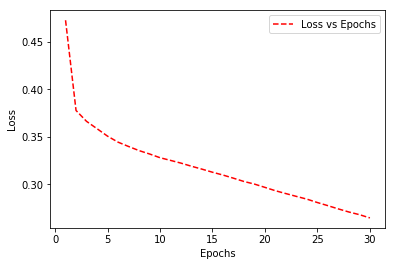

In [21]:
showTrainingLossPlot(fit_model)

KeyboardInterrupt: 